# Environment Setup & COCO Dataset Preparation

This cell initializes the project environment by installing pycocotools (essential for parsing COCO annotations) and setting up the COCO 2017 dataset. It creates a dedicated /content/coco directory, downloads the train2017 image set and corresponding annotations if not already present, and extracts them for further processing. Finally, it confirms successful setup by printing the number of images and available annotation files.

In [ ]:
!pip install pycocotools

!rm -rf /content/coco

!mkdir -p /content

import os

coco_dir = '/content/coco'
os.makedirs(coco_dir, exist_ok=True)

img_zip_url = 'http://images.cocodataset.org/zips/train2017.zip'
ann_zip_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'

if not os.path.exists(os.path.join(coco_dir, 'train2017')):
    print("Downloading COCO train2017 images...")
    !wget -q --show-progress -O {coco_dir}/train2017.zip {img_zip_url}
    print("Extracting train2017 images...")
    !unzip -q {coco_dir}/train2017.zip -d {coco_dir}
else:
    print("train2017 images already downloaded and extracted.")

if not os.path.exists(os.path.join(coco_dir, 'annotations')):
    print("Downloading COCO annotations...")
    !wget -q --show-progress -O {coco_dir}/annotations_trainval2017.zip {ann_zip_url}
    print("Extracting annotations...")
    !unzip -q {coco_dir}/annotations_trainval2017.zip -d {coco_dir}
else:
    print("Annotations already downloaded and extracted.")

print("Image folder contains:", len(os.listdir(os.path.join(coco_dir, 'train2017'))), "images")
print("Annotations available:", os.listdir(os.path.join(coco_dir, 'annotations')))


/content/coco/train 100%[===================>]  18.01G  32.7MB/s    in 11m 45s 
Extracting train2017 images...
/content/coco/annot 100%[===================>] 241.19M  41.4MB/s    in 6.3s    
Extracting annotations...
Image folder contains: 118287 images
Annotations available: ['captions_val2017.json', 'instances_train2017.json', 'person_keypoints_val2017.json', 'captions_train2017.json', 'person_keypoints_train2017.json', 'instances_val2017.json']


# Directory Validation for COCO Images

This cell verifies the presence of the COCO image directory (train2017) and displays the first few image filenames to ensure that the dataset was downloaded and extracted correctly. It's a quick sanity check before proceeding with image processing.

In [ ]:
import os

image_dir = '/content/coco/train2017/'
print("Exists?", os.path.exists(image_dir))
print("Files in dir:", os.listdir(image_dir)[:5])

Exists? True
Files in dir: ['000000530086.jpg', '000000289033.jpg', '000000564532.jpg', '000000137808.jpg', '000000168805.jpg']


# Importing Dependencies & Setting Seeds for Reproducibility

This cell imports all necessary libraries for the project, including image processing (cv2), visualization (matplotlib), data handling (numpy, pandas), and COCO dataset utilities (pycocotools). It also sets up TensorFlow and Keras modules for potential model integration. To ensure consistent results across runs, random seeds are fixed for both NumPy and TensorFlow.

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from pycocotools.coco import COCO

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)


# Filtering and Preprocessing Circular Object Annotations from COCO

This cell extracts and preprocesses images containing ‘sports ball’ objects from the COCO dataset—chosen due to their circular shape. After initializing the COCO API, it fetches relevant image and annotation IDs, then iteratively:

    - Loads images and corresponding segmentation masks.
    - Converts polygon-based masks to binary masks.
    - Filters out small annotations (area < 1000).
    - Resizes images and masks to 224×224 resolution.
    - Normalizes grayscale images and reshapes them for model compatibility.

The final output includes clean image-mask pairs focused on circular object segmentation, ready for further analysis or model training.









In [ ]:
from pycocotools.coco import COCO
import cv2
import os
import numpy as np
import random

ann_path = '/content/coco/annotations/instances_train2017.json'
image_dir = '/content/coco/train2017/'

coco = COCO(ann_path)

target_category = 'sports ball'
catIds = coco.getCatIds(catNms=[target_category])
imgIds = coco.getImgIds(catIds=catIds)

MAX_IMAGES = 10000
random.seed(42)
sampled_imgIds = random.sample(imgIds, min(MAX_IMAGES, len(imgIds)))

def polygon_to_mask(polygon, shape):
    mask = np.zeros(shape, dtype=np.uint8)
    pts = np.array(polygon, np.int32).reshape((-1, 2))
    cv2.fillPoly(mask, [pts], 1)
    return mask

img_data = []
mask_data = []

MIN_AREA = 1000

for img_id in sampled_imgIds:
    img_info = coco.loadImgs(img_id)[0]
    anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id, catIds=catIds, iscrowd=False))
    if len(anns) == 0:
        continue

    img_path = os.path.join(image_dir, img_info['file_name'])
    img = cv2.imread(img_path)
    if img is None:
        continue

    img_resized = cv2.resize(img, (224, 224))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) / 255.0
    gray = gray.reshape(224, 224, 1)

    mask_full = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    for ann in anns:
        if 'segmentation' in ann and isinstance(ann['segmentation'], list):
            if ann['area'] < MIN_AREA:
                continue
            for polygon in ann['segmentation']:
                poly_mask = polygon_to_mask(polygon, (img_info['height'], img_info['width']))
                mask_full = np.maximum(mask_full, poly_mask)

    if mask_full.sum() < MIN_AREA:
        continue

    mask_resized = cv2.resize(mask_full, (224, 224), interpolation=cv2.INTER_NEAREST)
    mask_resized = mask_resized.astype(np.float32)
    mask_resized = mask_resized.reshape(224, 224, 1)

    img_data.append(gray)
    mask_data.append(mask_resized)

print(f"Total usable 'sports ball' objects: {len(img_data)}")


loading annotations into memory...
Done (t=16.85s)
creating index...
index created!
Total usable 'sports ball' objects: 787


# Preparing Train-Validation Split for Segmentation Data

This cell organizes the preprocessed image and mask data into NumPy arrays and performs a train-validation split. It uses train_test_split from Scikit-learn to allocate 90% of the data for training and 10% for validation, ensuring reproducibility with a fixed random seed. This structured split helps in evaluating model generalization during training.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.stack(img_data)
masks_array = np.stack(mask_data)

print(f"X shape: {X.shape}")
print(f"masks_array shape: {masks_array.shape}")

X_train, X_val, masks_train, masks_val = train_test_split(
    X, masks_array, test_size=0.1, random_state=42
)

print(f"Train samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")


X shape: (787, 224, 224, 1)
masks_array shape: (787, 224, 224, 1)
Train samples: 708, Validation samples: 79


# MobileNetV2-Based Segmentation Model with Dice Loss

This cell defines a custom semantic segmentation model using a MobileNetV2 backbone pretrained on ImageNet. Since our input is grayscale, it is converted to RGB via a Lambda layer. The encoder layers of MobileNetV2 are frozen to retain pretrained features, and a custom decoder is built using progressive UpSampling2D and convolutional blocks to reconstruct the segmentation mask.

The model outputs a single-channel sigmoid-activated mask and is compiled with:

    - Dice Loss (optimized for imbalanced segmentation),
    - Adam optimizer, and
    - Accuracy as a metric.

The model architecture is printed via model.summary() for verification.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

input_layer = Input(shape=(224, 224, 1))

x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(input_layer)

backbone = MobileNetV2(input_tensor=x, include_top=False, weights='imagenet')

for layer in backbone.layers[:100]:
    layer.trainable = False

encoder_output = backbone.output

def conv_block(tensor, filters):
    x = Conv2D(filters, 3, padding='same')(tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

x = UpSampling2D()(encoder_output)
x = conv_block(x, 512)

x = UpSampling2D()(x)
x = conv_block(x, 256)

x = UpSampling2D()(x)
x = conv_block(x, 128)

x = UpSampling2D()(x)
x = conv_block(x, 64)

x = UpSampling2D()(x)
x = conv_block(x, 32)

mask_output = Conv2D(1, 1, activation='sigmoid', name='mask_output')(x)

model = Model(inputs=input_layer, outputs=mask_output)

model.compile(
    optimizer=Adam(1e-4),
    loss=dice_loss,
    metrics=['accuracy']
)

model.summary()


<ipython-input-10-c9aae3f56b2d>:18: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = MobileNetV2(input_tensor=x, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ lambda[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis

 Total params: 9,727,937 (37.11 MB)

 Trainable params: 9,330,561 (35.59 MB)

 Non-trainable params: 397,376 (1.52 MB)

# Model Training with Checkpoints, Learning Rate Scheduling, and Early Stopping

This cell initiates the training process for the segmentation model with robust training safeguards:

    - EarlyStopping halts training if validation loss stops improving for 6 epochs.
    - ReduceLROnPlateau lowers the learning rate by a factor of 0.5 if performance plateaus,
      helping the model converge better.
    - ModelCheckpoint saves the best-performing model (based on validation loss) for later use.

Training runs for up to 50 epochs with a batch size of 32 and includes real-time validation tracking. All checkpoints are saved under /content/model_checkpoints.

In [ ]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint_dir = '/content/model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

model_chk = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

history = model.fit(
    X_train,
    masks_train,
    validation_data=(X_val, masks_val),
    epochs=50,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stop, reduce_lr, model_chk],
    verbose=1
)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.6074 - loss: 0.9537
Epoch 1: val_loss improved from inf to 0.94084, saving model to /content/model_checkpoints/best_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6098 - loss: 0.9533 - val_accuracy: 0.2403 - val_loss: 0.9408 - learning_rate: 1.0000e-04
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8090 - loss: 0.9151
Epoch 2: val_loss did not improve from 0.94084
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - accuracy: 0.8099 - loss: 0.9149 - val_accuracy: 0.1630 - val_loss: 0.9480 - learning_rate: 1.0000e-04
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9010 - loss: 0.8889
Epoch 3: val_loss improved from 0.94084 to 0.94045, saving model to /content/model_checkpoints/best_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 269ms/step - accuracy: 0.9013 - loss: 0.8887 - val_accuracy: 0.3479 - val_loss: 0.9404 - learning_rate: 1.0000e-04
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9339 - loss: 0.8687
Epoch 4: val_loss improved from 0.94045 to 0.92848, saving model to /content/model_checkpoints/best_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.9339 - loss: 0.8686 - val_accuracy: 0.5452 - val_loss: 0.9285 - learning_rate: 1.0000e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9376 - loss: 0.8573
Epoch 5: val_loss improved from 0.92848 to 0.91215, saving model to /content/model_checkpoints/best_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.9379 - loss: 0.8572 - val_accuracy: 0.6878 - val_loss: 0.9122 - learning_rate: 1.0000e-04
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9582 - loss: 0.8451
Epoch 6: val_loss improved from 0.91215 to 0.91195, saving model to /content/model_checkpoints/best_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - accuracy: 0.9583 - loss: 0.8450 - val_accuracy: 0.6861 - val_loss: 0.9120 - learning_rate: 1.0000e-04
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9656 - loss: 0.8338
Epoch 7: val_loss improved from 0.91195 to 0.89055, saving model to /content/model_checkpoints/best_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - accuracy: 0.9657 - loss: 0.8338 - val_accuracy: 0.8075 - val_loss: 0.8906 - learning_rate: 1.0000e-04
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9728 - loss: 0.8237
Epoch 8: val_loss did not improve from 0.89055
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.9728 - loss: 0.8236 - val_accuracy: 0.7967 - val_loss: 0.8941 - learning_rate: 1.0000e-04
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9757 - loss: 0.8148
Epoch 9: val_loss improved from 0.89055 to 0.86374, saving model to /content/model_checkpoints/best_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 274ms/step - accuracy: 0.9757 - loss: 0.8148 - val_accuracy: 0.9253 - val_loss: 0.8637 - learning_rate: 1.0000e-04
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9769 - loss: 0.8076
Epoch 10: val_loss improved from 0.86374 to 0.85413, saving model to /content/model_checkpoints/best_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.9769 - loss: 0.8076 - val_accuracy: 0.9362 - val_loss: 0.8541 - learning_rate: 1.0000e-04
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9770 - loss: 0.8013
Epoch 11: val_loss improved from 0.85413 to 0.84929, saving model to /content/model_checkpoints/best_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.9770 - loss: 0.8013 - val_accuracy: 0.9220 - val_loss: 0.8493 - learning_rate: 1.0000e-04
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9804 - loss: 0.7942
Epoch 12: val_loss improved from 0.84929 to 0.84252, saving model to /content/model_checkpoints/best_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.9803 - loss: 0.7941 - val_accuracy: 0.9336 - val_loss: 0.8425 - learning_rate: 1.0000e-04
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9825 - loss: 0.7881
Epoch 13: val_loss improved from 0.84252 to 0.83730, saving model to /content/model_checkpoints/best_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.9825 - loss: 0.7881 - val_accuracy: 0.9327 - val_loss: 0.8373 - learning_rate: 1.0000e-04
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9820 - loss: 0.7802
Epoch 14: val_loss improved from 0.83730 to 0.83303, saving model to /content/model_checkpoints/best_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 276ms/step - accuracy: 0.9820 - loss: 0.7801 - val_accuracy: 0.9697 - val_loss: 0.8330 - learning_rate: 1.0000e-04
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9831 - loss: 0.7730
Epoch 15: val_loss improved from 0.83303 to 0.83161, saving model to /content/model_checkpoints/best_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - accuracy: 0.9831 - loss: 0.7730 - val_accuracy: 0.9480 - val_loss: 0.8316 - learning_rate: 1.0000e-04
Epoch 16/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9865 - loss: 0.7629
Epoch 16: val_loss did not improve from 0.83161
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.9865 - loss: 0.7629 - val_accuracy: 0.9291 - val_loss: 0.8316 - learning_rate: 1.0000e-04
Epoch 17/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9857 - loss: 0.7545
Epoch 17: val_loss improved from 0.83161 to 0.81388, saving model to /content/model_checkpoints/best_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 270ms/step - accuracy: 0.9857 - loss: 0.7544 - val_accuracy: 0.9442 - val_loss: 0.8139 - learning_rate: 1.0000e-04
Epoch 18/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9867 - loss: 0.7475
Epoch 18: val_loss did not improve from 0.81388
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9866 - loss: 0.7474 - val_accuracy: 0.8896 - val_loss: 0.8380 - learning_rate: 1.0000e-04
Epoch 19/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9862 - loss: 0.7410
Epoch 19: val_loss did not improve from 0.81388
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.9862 - loss: 0.7409 - val_accuracy: 0.8483 - val_loss: 0.8596 - learning_rate: 1.0000e-04
Epoch 20/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9852 - loss: 0.7380
Epoch 20: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 20: val_loss did not improve from 0.81388
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9852 - loss: 0.7380 - val

23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 270ms/step - accuracy: 0.9860 - loss: 0.7268 - val_accuracy: 0.9511 - val_loss: 0.8025 - learning_rate: 5.0000e-05
Epoch 22/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9896 - loss: 0.7172
Epoch 22: val_loss improved from 0.80250 to 0.78768, saving model to /content/model_checkpoints/best_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - accuracy: 0.9896 - loss: 0.7171 - val_accuracy: 0.9640 - val_loss: 0.7877 - learning_rate: 5.0000e-05
Epoch 23/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9923 - loss: 0.7054
Epoch 23: val_loss improved from 0.78768 to 0.78197, saving model to /content/model_checkpoints/best_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step - accuracy: 0.9923 - loss: 0.7054 - val_accuracy: 0.9707 - val_loss: 0.7820 - learning_rate: 5.0000e-05
Epoch 24/50
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9935 - loss: 0.6981
Epoch 24: val_loss did not improve from 0.78197
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.9935 - loss: 0.6981 - val_accuracy: 0.9731 - val_loss: 0.7867 - learning_rate: 5.0000e-05
Epoch 25/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9944 - loss: 0.6923
Epoch 25: val_loss did not improve from 0.78197
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.9944 - loss: 0.6923 - val_accuracy: 0.9781 - val_loss: 0.7991 - learning_rate: 5.0000e-05
Epoch 26/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9945 - loss: 0.6887
Epoch 26: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 26: val_loss did not improve from 0.78197
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.9945 - loss: 0.6887 - va

23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - accuracy: 0.9942 - loss: 0.6887 - val_accuracy: 0.9668 - val_loss: 0.7648 - learning_rate: 2.5000e-05
Epoch 28/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9935 - loss: 0.6830
Epoch 28: val_loss did not improve from 0.76485
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9936 - loss: 0.6829 - val_accuracy: 0.9733 - val_loss: 0.7746 - learning_rate: 2.5000e-05
Epoch 29/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9952 - loss: 0.6763
Epoch 29: val_loss did not improve from 0.76485
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.9952 - loss: 0.6762 - val_accuracy: 0.9738 - val_loss: 0.7675 - learning_rate: 2.5000e-05
Epoch 30/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9955 - loss: 0.6731
Epoch 30: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 30: val_loss did not improve from 0.76485
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.9955 - loss: 0.6731 - va

# Circle Extraction & Visualization from Segmentation Masks

This cell performs a post-processing step to detect circular shapes from segmentation masks and visually confirm the accuracy of the segmentation.

Key functionalities include:

1. extract_all_circle_params: Detects connected components in the binary mask and fits a minimum enclosing circle for each. It returns both pixel-level and normalized coordinates (center and radius).

2. visualize_mask_and_circle: Randomly samples a few images and displays:

       - The original image with overlaid detected circles,
       - The ground truth mask,
       - A mask reconstructed using predicted circle parameters,
       - A clean canvas showing centers and radii with annotated circle overlays.

This step ensures that the model not only segments circular objects but also enables accurate geometric interpretation, which is essential for downstream tasks like tracking or measurements.









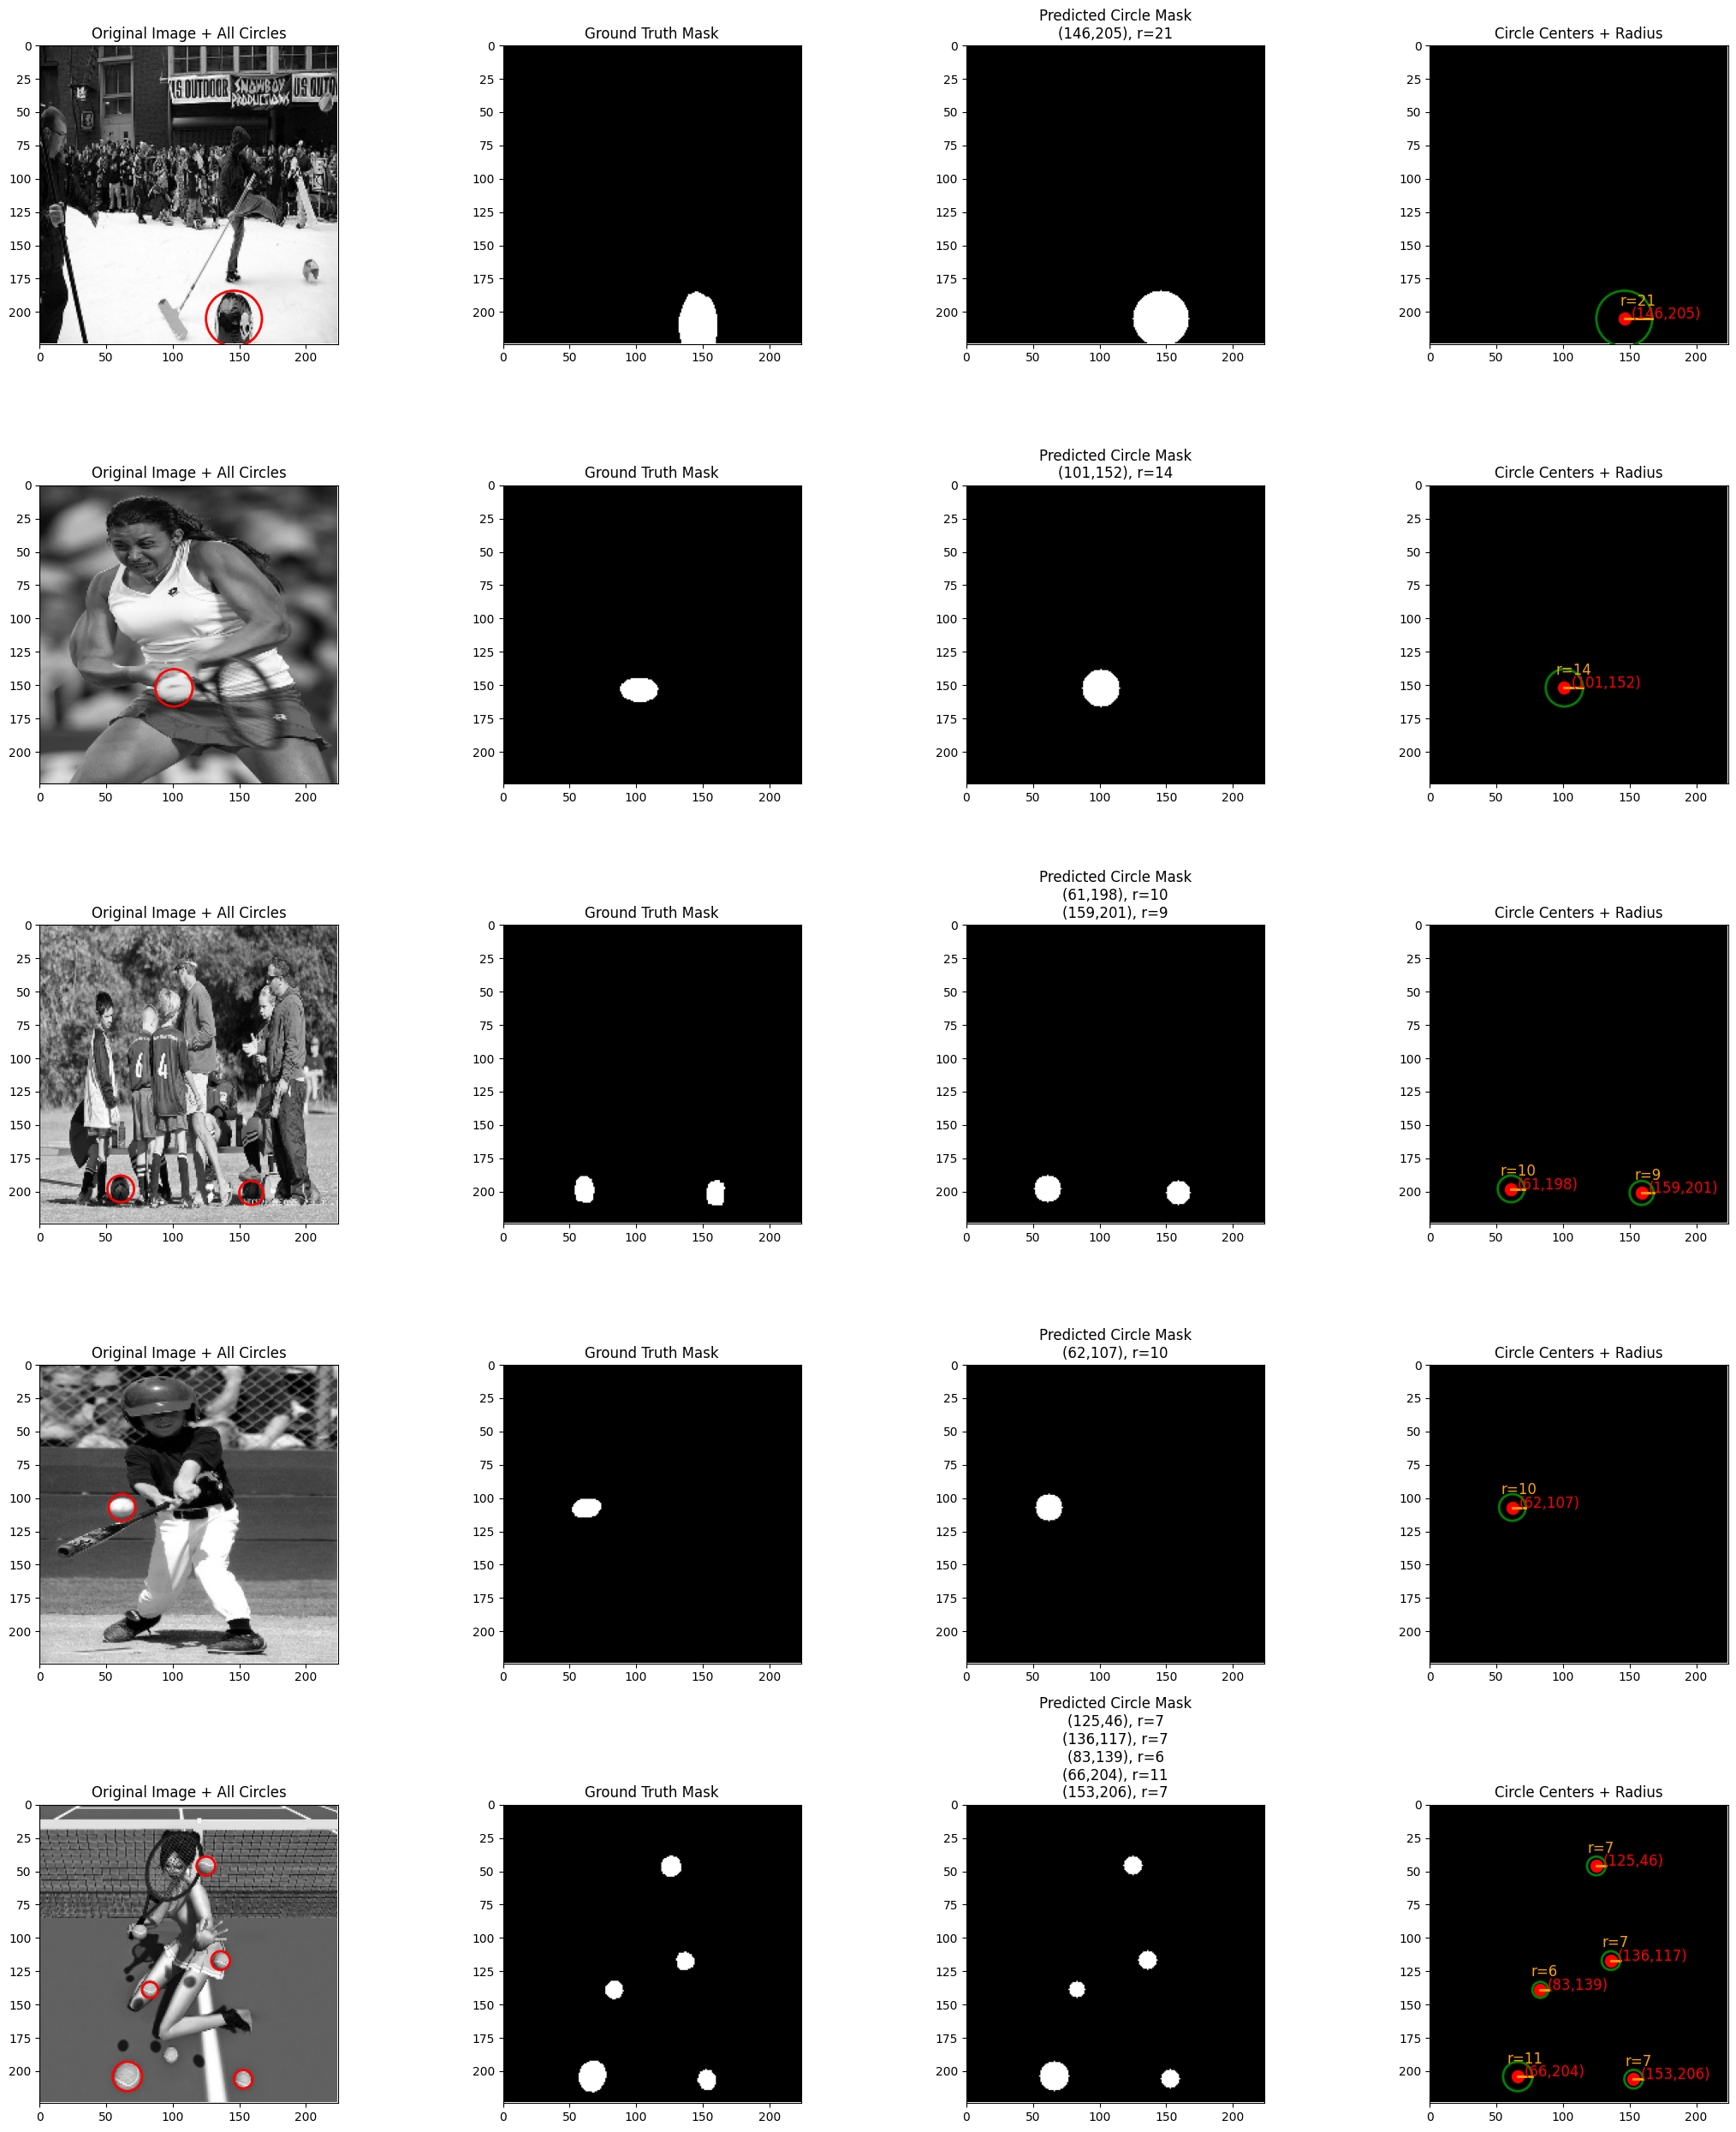

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import cv2

D_FACTOR = 15

def extract_all_circle_params(mask):
    h, w = mask.shape[:2]
    mask_gray = (mask[:, :, 0] * 255).astype(np.uint8)

    num_labels, labels = cv2.connectedComponents(mask_gray)

    circles = []
    for label in range(1, num_labels):
        component_mask = (labels == label).astype(np.uint8) * 255
        contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            continue
        cnt = contours[0]
        (x_pixel, y_pixel), r_pixel = cv2.minEnclosingCircle(cnt)

        x_norm = (x_pixel - w/2) / (w/2)
        y_norm = (y_pixel - h/2) / (h/2)
        r_norm = r_pixel / (np.mean([h, w]) / D_FACTOR)

        circles.append({
            'x_pixel': int(x_pixel),
            'y_pixel': int(y_pixel),
            'r_pixel': int(r_pixel),
            'x_norm': x_norm,
            'y_norm': y_norm,
            'r_norm': r_norm
        })

    return circles


def visualize_mask_and_circle(X, masks, num_samples=5):
    idxs = np.random.choice(len(X), num_samples, replace=False)
    fig, axes = plt.subplots(num_samples, 4, figsize=(22, 5 * num_samples))

    for i, idx in enumerate(idxs):
        img = X[idx, :, :, 0]
        mask = masks[idx]

        h, w = img.shape
        circles = extract_all_circle_params(mask)

        axes[i, 0].imshow(img, cmap='gray')
        for c in circles:
            circ = Circle((c['x_pixel'], c['y_pixel']), c['r_pixel'], edgecolor='red', facecolor='none', lw=2)
            axes[i, 0].add_patch(circ)
        axes[i, 0].set_title("Original Image + All Circles")
        axes[i, 0].set_xlim(0, w)
        axes[i, 0].set_ylim(h, 0)

        axes[i, 1].imshow(mask[:, :, 0], cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].set_xlim(0, w)
        axes[i, 1].set_ylim(h, 0)

        pred_mask = np.zeros_like(mask[:, :, 0])
        title_info = []
        for c in circles:
            cv2.circle(pred_mask, (c['x_pixel'], c['y_pixel']), c['r_pixel'], 1, thickness=-1)
            title_info.append(f"({c['x_pixel']},{c['y_pixel']}), r={c['r_pixel']}")
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title("Predicted Circle Mask\n" + "\n".join(title_info))
        axes[i, 2].set_xlim(0, w)
        axes[i, 2].set_ylim(h, 0)

        white_bg = np.ones_like(img) * 255
        axes[i, 3].imshow(white_bg, cmap='gray')
        axes[i, 3].set_title("Circle Centers + Radius")
        axes[i, 3].set_xlim(0, w)
        axes[i, 3].set_ylim(h, 0)
        axes[i, 3].set_aspect('equal')

        for j, c in enumerate(circles):
            x, y, r = c['x_pixel'], c['y_pixel'], c['r_pixel']
            axes[i, 3].scatter(x, y, c='red', s=100)
            axes[i, 3].text(x + 5, y, f"({x},{y})", color='red', fontsize=12)
            axes[i, 3].add_patch(Circle((x, y), r, edgecolor='green', facecolor='none', lw=2))
            axes[i, 3].plot([x, x + r], [y, y], color='orange', lw=2)
            axes[i, 3].text(x + r / 2, y - 10, f"r={r}", color='orange', fontsize=12, ha='center')

    plt.tight_layout()
    plt.show()

visualize_mask_and_circle(X_val, masks_val, num_samples=5)


# Validation Performance Evaluation of the Segmentation Model

This cell evaluates the trained segmentation model on the validation dataset, computing the final loss and accuracy metrics. These results summarize the model’s ability to generalize and accurately predict masks on unseen data, providing a quantitative measure of segmentation quality before deployment or further analysis.









In [ ]:
val_results = model.evaluate(
    X_val,
    masks_val,
    verbose=0
)

print(f"Final Validation Loss: {val_results[0]:.4f}")
print(f"Final Validation Accuracy: {val_results[1]:.4f}")


Final Validation Loss: 0.7648
Final Validation Accuracy: 0.9668


# Training and Validation Performance Visualization

This cell visualizes the model’s learning progress by plotting loss and accuracy curves over training epochs. The loss subplot shows how the binary cross-entropy loss evolves, indicating improvements in segmentation quality. The accuracy subplot tracks the model's correctness in pixel-wise predictions on both training and validation sets. These plots help diagnose underfitting, overfitting, or convergence issues during training.

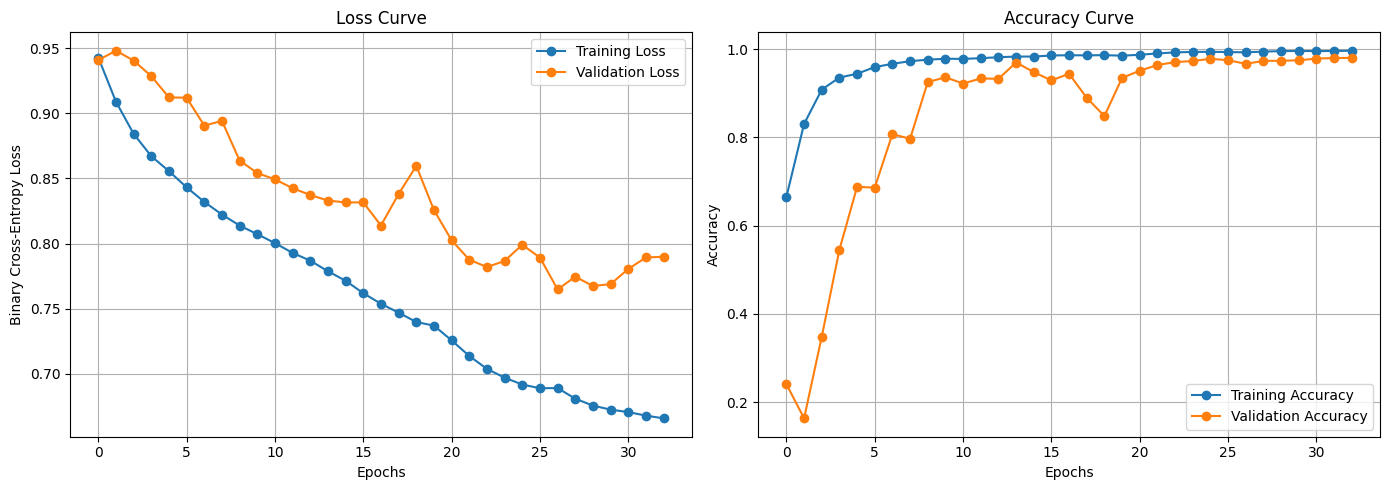

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Detailed Pixel-Level Segmentation Metrics and Visualization

This cell provides an in-depth evaluation of the segmentation model's pixel-wise performance on the validation set:

    - IoU (Intersection over Union) and Dice Coefficient quantify overlap
      quality between predicted and ground truth masks.

    - A classification report shows precision, recall, f1-score for each pixel
      class (background vs object).

    - The confusion matrix heatmap visualizes true vs predicted pixel counts,
      aiding error analysis.

    - The ROC curve with AUC score illustrates the model’s ability to
      discriminate pixels at varying classification thresholds.

Together, these metrics give a comprehensive understanding of segmentation accuracy and model robustness beyond just loss and accuracy values.

Pixel-wise IoU: 0.3140
Pixel-wise Dice Coefficient: 0.4779

Classification Report (Pixel-wise):
              precision    recall  f1-score   support

         0.0     0.9924    0.9735    0.9828   3874582
         1.0     0.3698    0.6753    0.4779     89322

    accuracy                         0.9668   3963904
   macro avg     0.6811    0.8244    0.7304   3963904
weighted avg     0.9783    0.9668    0.9715   3963904



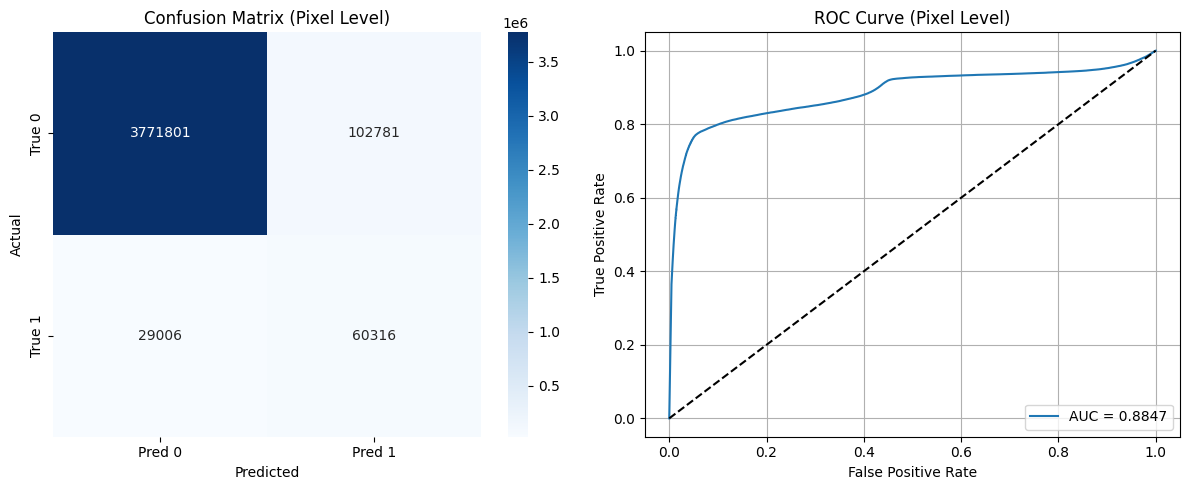

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np

def iou_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union if union != 0 else 0

def dice_coef(y_true, y_pred):
    intersection = 2 * np.sum(y_true * y_pred)
    denominator = np.sum(y_true) + np.sum(y_pred)
    return intersection / denominator if denominator != 0 else 0

y_pred_prob = model.predict(X_val, verbose=0)
y_pred_bin = (y_pred_prob > 0.5).astype(np.uint8)

y_true_flat = masks_val.flatten()
y_pred_flat = y_pred_bin.flatten()
y_pred_prob_flat = y_pred_prob.flatten()

iou = iou_score(y_true_flat, y_pred_flat)
dice = dice_coef(y_true_flat, y_pred_flat)

print(f"Pixel-wise IoU: {iou:.4f}")
print(f"Pixel-wise Dice Coefficient: {dice:.4f}")
print("\nClassification Report (Pixel-wise):")
print(classification_report(y_true_flat, y_pred_flat, digits=4))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(wspace=0.3)

cm = confusion_matrix(y_true_flat, y_pred_flat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'], ax=axes[0])
axes[0].set_title("Confusion Matrix (Pixel Level)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

auc_score = roc_auc_score(y_true_flat, y_pred_prob_flat)
fpr, tpr, thresholds = roc_curve(y_true_flat, y_pred_prob_flat)
axes[1].plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve (Pixel Level)")
axes[1].legend(loc="lower right")
axes[1].grid(True)

plt.tight_layout()
plt.show()
